In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
TRAIN_VAL_SPLIT = 1000
WINDOW_SIZE = 30
BATCH_SIZE = 32
SHUFFER_BUFFER_SIZE = 1000

In [3]:
def build_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
from util import load_synthesized_data

df_train, df_val = load_synthesized_data(split=1000)
y_train = df_train['y'].values

dataset = build_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, SHUFFER_BUFFER_SIZE)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Lambda, Bidirectional, LSTM, Dense

def build_model():
    model = Sequential([
        Conv1D(32, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
        LSTM(32, return_sequences=True),
        LSTM(32, return_sequences=True),
        Dense(1),
        Lambda(lambda x: x * 200.0)
    ])
    return model

In [6]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from util import clear_env

clear_env()

model = build_model()
model.compile(loss=Huber(), optimizer=SGD(lr=1e-8, momentum=0.9))

def learning_rate(epoch):
    return 1e-8 * 10**(epoch / 20)

lr_schedule = LearningRateScheduler(learning_rate)

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

W0807 21:57:02.466140 13276 deprecation.py:323] From d:\Dev\Miniconda3\envs\tf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[1e-08, 0.0001, 0, 30]

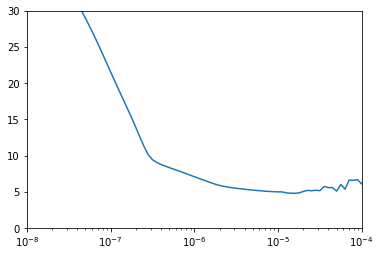

In [7]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

Select learning rate = 1e-5.

In [8]:
clear_env()

model = build_model()
model.compile(loss=Huber(), optimizer=SGD(lr=1e-5, momentum=0.9), metrics=['mae'])

history = model.fit(dataset, epochs=200, verbose=0)

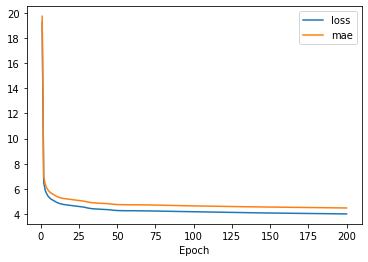

In [9]:
from util import plot_history

plot_history(history, metrics=['loss', 'mae'])

In [10]:
from util import validate

def build_test_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return ds

def validate_model(model, df_val, window_size):
    dataset_val = build_test_dataset(df_val['y'].values, WINDOW_SIZE)
    forecast = model.predict(dataset_val)
    df_forecast = df_val.copy()
    df_forecast['y_hat'] = np.nan
    df_forecast.iloc[window_size:, df_forecast.columns.get_loc('y_hat')] = forecast[:-1, -1, 0]
    validate(df_forecast[window_size:])

MSE: 72.34008198370611, MAE: 6.4050418439219445


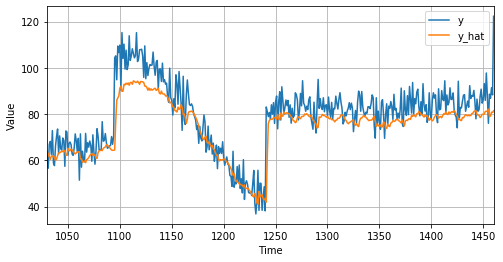

In [11]:
validate_model(model, df_val, WINDOW_SIZE)